# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP - redukcja wymiarowości

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

**Uwaga:** jeżeli notebook będzie wykonywał się zbyt długo, to można ustawić wyższy próg popularności, żeby uzyskać mniejszy podzbiór najbardziej popularnych piosenek.

In [2]:
import ast
from fast_langdetect import detect as detect_language


def extract_artist_id(df_housing_tracks: pd.DataFrame) -> pd.DataFrame:
    df_housing_tracks["main_artist_id"] = df_housing_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_housing_tracks


def remove_weird_genres(df_housing_artists: pd.DataFrame) -> pd.DataFrame:
    all_genres = []
    for song_genres in df_housing_artists["genres"]:
        all_genres.extend(ast.literal_eval(song_genres))

    df_housing_genres = pd.Series(all_genres).value_counts().reset_index()

    weird_genres = df_housing_genres.loc[df_housing_genres["count"] < 150, "index"]
    weird_genres = set(weird_genres.tolist())

    to_keep = []
    for song_genres in df_housing_artists["genres"]:
        song_genres = set(ast.literal_eval(song_genres))
        not_all_weird = len(song_genres - weird_genres) > 0
        to_keep.append(not_all_weird)

    df_housing_artists = df_housing_artists[to_keep]
    return df_housing_artists


def filter_english_only(df_housing_tracks: pd.DataFrame) -> pd.DataFrame:
    english = [
        detect_language(title[:100], low_memory=False)["lang"] == "en"
        for title in df_housing_tracks["name"]
    ]
    return df_housing_tracks[english]

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.

2. Załaduj pliki `artists.parquet` i `tracks.parquet` do zmiennych `df_housing_artists` i `df_housing_tracks`.

In [3]:
df_housing_artists = pd.read_csv("artists.csv")
df_housing_tracks = pd.read_csv("tracks.csv")

3. Usuń wiersze z wartościami brakującymi z obu ramek danych.

In [4]:
df_housing_tracks = df_housing_tracks[df_housing_tracks.notna().any(axis=1)]
df_housing_artists = df_housing_artists[df_housing_artists.notna().any(axis=1)]

4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.

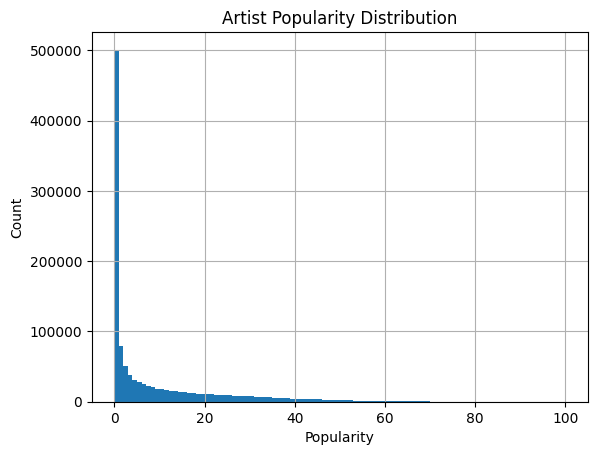

In [5]:
df_housing_artists.hist(column="popularity", bins=100)
plt.title("Artist Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

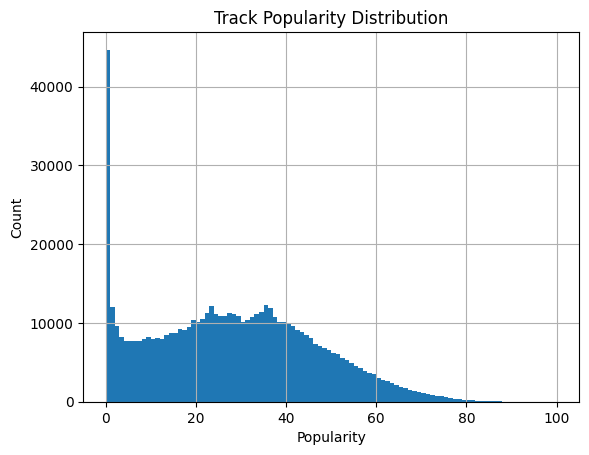

In [6]:
df_housing_tracks.hist(column="popularity", bins=100)
plt.title("Track Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

5. Dokonaj filtrowania:
   - pozostaw artystów z popularnością >= 55
   - pozostaw piosenki z popularnością >= 55
   - usuń piosenki trwające powyżej 600000 ms (10 minut)
   - użyj funkcji `remove_weird_genres()`, żeby usunąć artystów z ekstremalnie rzadkich gatunków muzycznych
   - użyj funkcji `filter_english_only()`, aby pozostawić tylko anglojęzyczne tytuły

In [7]:
df_housing_tracks.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [8]:
df_housing_artists_filtered = df_housing_artists[df_housing_artists["popularity"] >= 55]
df_housing_tracks_filtered = df_housing_tracks[
    (df_housing_tracks["popularity"] >= 55)
    & (df_housing_tracks["duration_ms"] <= 600000)
]

df_housing_artists_filtered = remove_weird_genres(df_housing_artists_filtered)
df_housing_tracks_filtered = filter_english_only(df_housing_tracks_filtered)

6. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.

In [9]:
df_housing_tracks_filtered = extract_artist_id(df_housing_tracks)

7. Połącz ramki w jedną, `df_housing_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`

In [10]:
df_housing_tracks_filtered.columns, df_housing_artists_filtered.columns

(Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
        'id_artists', 'release_date', 'danceability', 'energy', 'key',
        'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'time_signature', 'main_artist_id'],
       dtype='object'),
 Index(['id', 'followers', 'genres', 'name', 'popularity'], dtype='object'))

In [11]:
df_housing_songs = pd.merge(
    df_housing_tracks_filtered,
    df_housing_artists_filtered,
    left_on="main_artist_id",
    right_on="id",
    suffixes=["_track", "_artist"],
)

8. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.

In [12]:
df_housing_songs = df_housing_songs.drop_duplicates(
    subset=["name_track", "name_artist"]
)

9. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_housing_songs_info`.

In [13]:
songs_info_cols = ["name_track", "name_artist", "genres"]

In [14]:
df_housing_songs_info = df_housing_songs[songs_info_cols]
df_housing_songs = df_housing_songs.drop(columns=songs_info_cols)

10. Stwórz nową ramkę `df_housing_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:

In [15]:
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

In [16]:
df_housing_songs_features = df_housing_songs[songs_features_cols]

11. Wypisz finalną liczbę piosenek (rozmiar zbioru).

In [17]:
print("Number of songs and features: ", df_housing_songs_features.shape)

Number of songs and features:  (110158, 9)


Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadkU PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [18]:
import sklearn

sklearn.set_config(transform_output="pandas")

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df_housing_songs_features)

In [20]:
from typing import Optional

from IPython.display import display
from sklearn.decomposition import PCA
from umap.umap_ import UMAP


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        # PCA
        self.pca = PCA(n_components=2, random_state=0)
        self.pca.fit(X)

        self.X_pca = self.pca.transform(X)

        # UMAP
        self.umap = UMAP(n_components=2, random_state=0, low_memory=False)
        self.umap.fit(X)

        self.X_umap = self.umap.transform(X)
        self.X = X

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(len(self.X))

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # axes[0] - PCA, axes[1] - UMAP
        scatter_pca = axes[0].scatter(
            np.asarray(self.X_pca)[:, 0],
            np.asarray(self.X_pca)[:, 1],
            c=labels,
            s=1,
            cmap="viridis",
        )
        axes[0].set_title("PCA")
        axes[0].set_xlabel("PCA Component 1")
        axes[0].set_ylabel("PCA Component 2")
        if labels is not None:
            axes[0].legend(*scatter_pca.legend_elements(), title="Labels")

        scatter_umap = axes[1].scatter(
            np.asarray(self.X_umap)[:, 0],
            np.asarray(self.X_umap)[:, 1],
            c=labels,
            s=1,
            cmap="viridis",
        )
        axes[1].set_title("UMAP")
        axes[1].set_xlabel("UMAP Component 1")
        axes[1].set_ylabel("UMAP Component 2")
        if labels is not None:
            axes[1].legend(*scatter_umap.legend_elements(), title="Labels")

        fig.suptitle("Clustering visualization")
        plt.show()

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


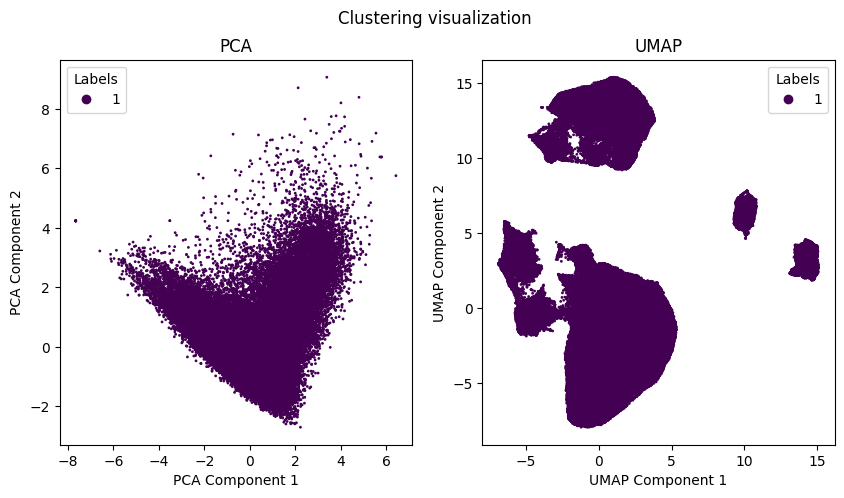

In [21]:
clustering_visualizer = ClusteringVisualizer(X)
clustering_visualizer.visualize()

W UMAP wyraźnie widzimy strukturę klastrów. W PCA na siłę można by wyznaczyć 2 clustry o różnej gęstości dla nie są one tak wyraźne jak przy UMAP. Przy nieliniowym UMAP dostaliśmy wyraźnie lepsze wyniki.

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radarowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [22]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale

from hdbscan import HDBSCAN


class ClusteringAnalyzer(ABC):
    def __init__(
        self,
        df_housing_songs_info: pd.DataFrame,
        clustering_visualizer: ClusteringVisualizer,
    ):
        self.df_housing_songs_info = df_housing_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres]
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = df_housing_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: DBSCAN) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_housing_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_housing_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(X_cluster, cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self,
        X: pd.DataFrame,
        cluster_songs_info: pd.DataFrame,
        cluster_probas: np.ndarray,
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

Number of clusters: 1


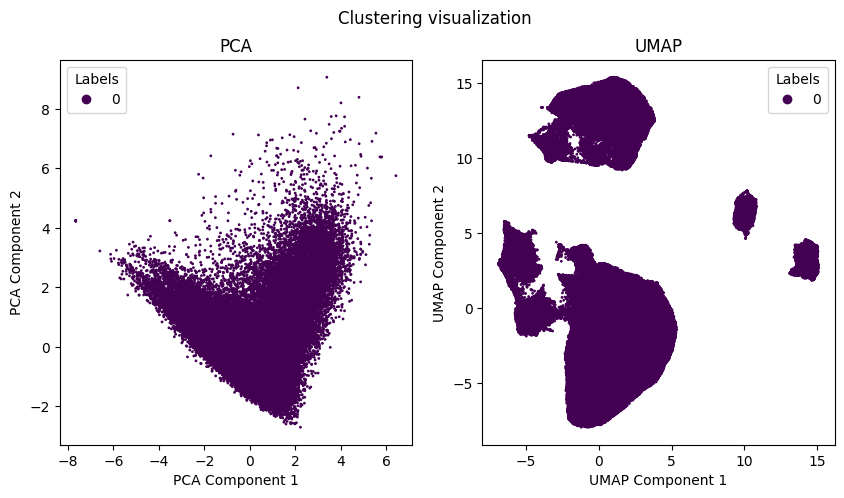

Cluster 0 size: 110158


,Track,Artist
0,Dating,A.R. Rahman
1,My Lady And Me - 2010 Digital Remaster,Little River Band
2,Don't Leave Me This Way (feat. Teddy Pendergra...,Harold Melvin & The Blue Notes
3,Vallan Vallende,Celia Cruz
4,Difícil,El Tri
5,Can You Dig It - Alternate Mix,The Monkees
6,Wait for Love,Luther Vandross
7,Walk On Water,Eddie Money
8,West Bound And Down,Jerry Reed
9,Pyar Karne Wale - Shaan / Soundtrack Version,Asha Bhosle


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'mellow gold', 'album rock', 'soft rock', 'folk rock', 'latin', 'soul', 'desi pop']


In [23]:
from sklearn.cluster import KMeans


clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_housing_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


Number of clusters: 3
CH-index value: 19567.64


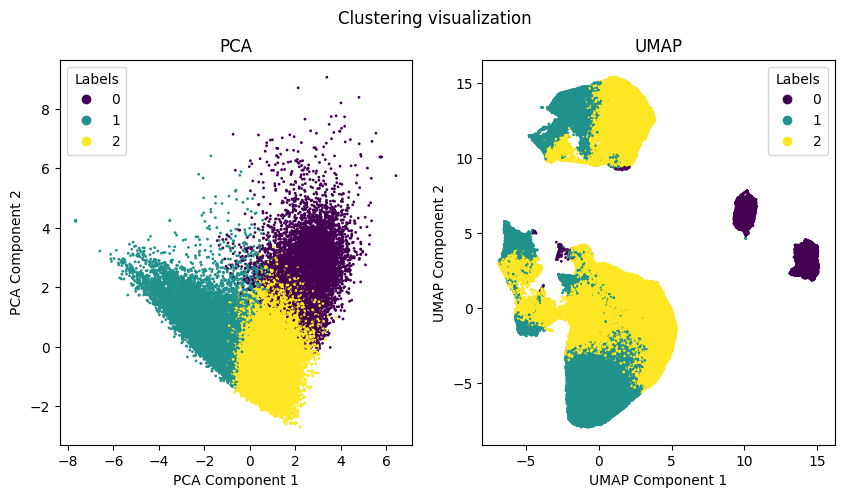

Cluster 0 size: 8777


,Track,Artist
0,Dándole,Arte Elegante
1,Putain d'époque,Lujipeka
2,okay,LANY
3,Ahora Dice Que Me Ama,Bandaga
4,Luxury,Azealia Banks
5,Me Llamas,Arcangel
6,Djomb - Bien ou quoi,Bosh
7,MEVTR,Damso
8,Vaillante,YL
9,Lost,Frank Ocean


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'french hip hop', 'trap', 'southern hip hop', 'pop', 'pop urbaine', 'hardcore hip hop']
Cluster 1 size: 35386


,Track,Artist
0,Vas a Ver,José José
1,Don't Go Near The Water - Remastered 2009,The Beach Boys
2,Another Try,America
3,I Know It's True,James Brown & The Famous Flames
4,I Wish You Love,Frank Sinatra
5,Helpless Dancer,The Who
6,Punchiri Thanjum,Shankar Mahadevan
7,Shades of Gray - 2007 Remaster,The Monkees
8,Here Comes the Night,Ben E. King
9,[Love Is] The Tender Trap,Frank Sinatra


Top 10 genres in the cluster: ['adult standards', 'vocal jazz', 'mellow gold', 'rock', 'lounge', 'classic rock', 'soft rock', 'soul', 'folk rock', 'desi pop']
Cluster 2 size: 65995


,Track,Artist
0,Fake ID,Riton
1,Gloria (feat. Van Morrison) - Mono Version,Them
2,Primitive Cool,Mick Jagger
3,Du bist mein erster Gedanke,Julio Iglesias
4,KRIMINELL,Kianush
5,Danger Ahead,Electric Light Orchestra
6,Love's No Friend,Rainbow
7,Pelo Suelto,Gloria Trevi
8,Sé Morir,Andrés Cepeda
9,Tainu Leke,Sonu Nigam


Top 10 genres in the cluster: ['rock', 'classic rock', 'album rock', 'mellow gold', 'soft rock', 'latin', 'hard rock', 'folk rock', 'dance pop', 'art rock']


In [24]:
clustering_kmeans3 = KMeans(n_clusters=3, n_init="auto", random_state=0)
clustering_kmeans3.fit(X)

kmeans_analyzer.analyze_clustering(X, clustering_kmeans3)

Ewidentnie dla K-means podana ilość klastrów była za mała, widać to na przykładzie dwóch wysepek tworzących dwa małe oczywiste klastry obok siebie - jednakże wzięte są jako jeden klaster w K-means. Jednakże patrząc tylko po gatunkach widać, że np. `Cluster 2` ewidentnie grupuje różne rodzaje rocka, z kolei `Cluster 0` głównie rap.

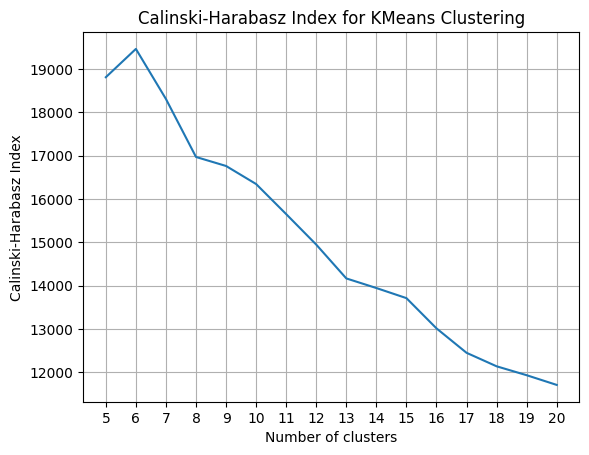

In [25]:
calinski_harabasz_scores = []

best_clustering = None
best_score = -np.inf

for n_clusters in range(5, 21):
    clustering_kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=0)
    clustering_kmeans.fit(X)

    calinski_harabasz_score_value = calinski_harabasz_score(
        X, clustering_kmeans.labels_
    )
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    if calinski_harabasz_score_value > best_score:
        best_score = calinski_harabasz_score_value
        best_clustering = clustering_kmeans

plt.plot(calinski_harabasz_scores)
plt.title("Calinski-Harabasz Index for KMeans Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.xticks(range(len(calinski_harabasz_scores)), range(5, 21))
plt.grid()

Number of clusters: 6
CH-index value: 19464.32


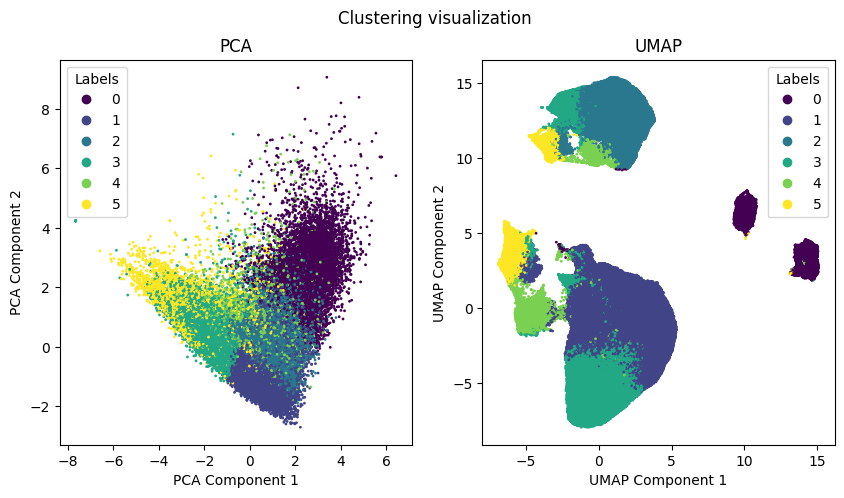

Cluster 0 size: 8490


,Track,Artist
0,Putain d'époque,Lujipeka
1,Dándole,Arte Elegante
2,okay,LANY
3,Ahora Dice Que Me Ama,Bandaga
4,Luxury,Azealia Banks
5,Soleil,Roméo Elvis
6,Me Llamas,Arcangel
7,MEVTR,Damso
8,Augenblick (feat. Summer Cem),KC Rebell
9,Djomb - Bien ou quoi,Bosh


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'french hip hop', 'southern hip hop', 'pop', 'pop urbaine', 'hardcore hip hop']
Cluster 1 size: 40547


,Track,Artist
0,Primitive Cool,Mick Jagger
1,Sachi Ye Kahani Hai,Jatin-Lalit
2,Fortunate Son,Creedence Clearwater Revival
3,Gloria (feat. Van Morrison) - Mono Version,Them
4,Sé Morir,Andrés Cepeda
5,Agualluvia,Vicente Garcia
6,Our Day Will Come,Frankie Valli
7,Los Idiotas,Calle 13
8,Ik Junoon (Paint It Red),Vishal Dadlani
9,Back in N.Y.C. - New Stereo Mix,Genesis


Top 10 genres in the cluster: ['rock', 'classic rock', 'mellow gold', 'album rock', 'soft rock', 'latin', 'folk rock', 'hard rock', 'regional mexican', 'latin pop']
Cluster 2 size: 22228


,Track,Artist
0,Stingy,Ginuwine
1,No Te Puedo Olvidar - En Vivo,Antony Santos
2,Young Guns (Go for It!),Wham!
3,Conquistador,Procol Harum
4,Ya no somos amantes,Daniela Romo
5,Shuffering & Shmiling (Parts 1 & 2),Fela Kuti
6,Nazar Nazar,Udit Narayan
7,Tu Verdad,J Balvin
8,Poncho Konos,T3R Elemento
9,Spinning Around,Kylie Minogue


Top 10 genres in the cluster: ['rock', 'classic rock', 'latin', 'album rock', 'desi pop', 'soft rock', 'dance pop', 'filmi', 'mellow gold', 'sufi']
Cluster 3 size: 23675


,Track,Artist
0,Another Try,America
1,Spanish Eyes,Charlie Rich
2,[Love Is] The Tender Trap,Frank Sinatra
3,I Don't Wanna Play House - Single Version,Tammy Wynette
4,"Love, Me",Collin Raye
5,Anything Goes,Ella Fitzgerald
6,The Song Is Ended (But The Melody Lingers On),Nat King Cole
7,Do What You Gotta Do,Roberta Flack
8,Changes - 1990 Remaster,David Bowie
9,Take A Little Time To Smile,Peggy Lee


Top 10 genres in the cluster: ['adult standards', 'mellow gold', 'vocal jazz', 'lounge', 'classic rock', 'rock', 'folk rock', 'soft rock', 'soul', 'brill building pop']
Cluster 4 size: 7803


,Track,Artist
0,Amoreena - Live Radio Broadcast,Elton John
1,"Emotions - Live at MTV Unplugged, Kaufman Asto...",Mariah Carey
2,The Night They Drove Old Dixie Down - Live at ...,Bob Dylan
3,"Song Sung Blue - Live At The Greek Theatre, Lo...",Neil Diamond
4,"I Shall Be Released - Live at LA Forum, Inglew...",Bob Dylan
5,Bill Bailey - Live,Sam Cooke
6,Come On In My Kitchen - Live,Steve Miller Band
7,I Saw Mommy Kissing Santa Claus,The Jackson 5
8,Kehna Ghalat Ghalat,Nusrat Fateh Ali Khan
9,Sweet Sixteen,B.B. King


Top 10 genres in the cluster: ['rock', 'classic rock', 'album rock', 'mellow gold', 'soft rock', 'adult standards', 'folk rock', 'rock en espanol', 'hard rock', 'art rock']
Cluster 5 size: 7415


,Track,Artist
0,Halo of Flies,Alice Cooper
1,The Morning: Another Morning - Remastered 2017,The Moody Blues
2,Blessed Relief,Frank Zappa
3,Bourée,Jethro Tull
4,About Today,The National
5,Jim Cain,Bill Callahan
6,Yours Is My Heart Alone,Ray Conniff
7,Loving You Is on My Mind,The Meters
8,"The James Bond Theme (From ""Dr. No"")",John Barry
9,Little Wing,Stevie Ray Vaughan


Top 10 genres in the cluster: ['rock', 'adult standards', 'classic rock', 'album rock', 'art rock', 'vocal jazz', 'lounge', 'jazz', 'desi pop', 'filmi']


In [26]:
kmeans_analyzer.analyze_clustering(X, best_clustering)

Klasteryzacja wygląda trochę lepiej ale za to teraz podzieliliśmy niektóre Klastry które nie powinny być raczej podzielone, jak np `Cluster1` i `Cluster2`, diagram radarowy wyglada dla tych klastrów identycznie oraz gatunki wyglądają podobnie. Za to dwie małe wysepki zawierające prawdopodobnie osobno hip hop i rap nadal należą do tego samego clustra.

Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

Number of clusters: 343
Percentage of noise points: 31.08%
CH-index value: 114.35


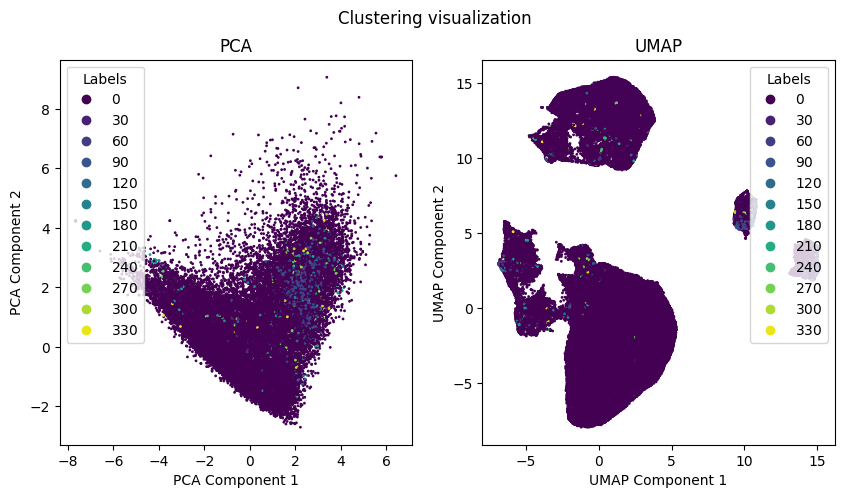

Cluster 0 size: 52556


,Track,Artist
0,Daniel Prayed,Patty Loveless
1,Lightning Rose,Jefferson Starship
2,Difícil,El Tri
3,Santa Monica,Savage Garden
4,Walk On Water,Eddie Money
5,The Worst Is Yet To Come - Remastered,Merle Haggard
6,Cup Of Tea,Kacey Musgraves
7,Lord Have Mercy on the Working Man,Travis Tritt
8,"Sigueme, Veras Felicidad",Los Iracundos
9,Wedding Bell Blues - Digitally Remastered: 1997,The 5th Dimension


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'mellow gold', 'soft rock', 'folk rock', 'album rock', 'latin', 'latin pop', 'country rock']
Cluster 1 size: 18526


,Track,Artist
0,Minchagi Neenu,Sonu Nigam
1,Hay algo en ella,Dyango
2,Break Away,The Beach Boys
3,The Wild Boys,Duran Duran
4,American Pie,Madonna
5,Poncho Konos,T3R Elemento
6,It Doesn't Matter,Stephen Stills
7,Toes Across The Floor,Blind Melon
8,Ya no somos amantes,Daniela Romo
9,Private Dancer - Single Edit,Tina Turner


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'latin', 'mellow gold', 'soft rock', 'album rock', 'desi pop', 'dance pop', 'filmi']
Cluster 61 size: 1016


,Track,Artist
0,Electro Movimiento,Calle 13
1,Thank You,Busta Rhymes
2,"Young, Wild & Free (feat. Bruno Mars)",Snoop Dogg
3,Only If You Want It,Eazy-E
4,Back That Azz Up,JUVENILE
5,Dead Cell,Papa Roach
6,Crazy = Genius,Panic! At The Disco
7,Niggaz My Height Don't Fight,Eazy-E
8,Break Stuff,Limp Bizkit
9,Coño,Jason Derulo


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'southern hip hop', 'trap', 'pop', 'dance pop', 'hardcore hip hop', 'alternative metal']
Cluster 76 size: 598


,Track,Artist
0,Bella,UZI
1,Oasis pétou,Naps
2,Good Weed Bad B*tch,K CAMP
3,Young Grizzley World (feat. A Boogie Wit Da Ho...,Tee Grizzley
4,Ayye,Mac Miller
5,I Don't Care,Cheryl
6,ZART,Nimo
7,Happily Ever After,Case
8,Sinne,Sarhad
9,Knee Deep - Deep As A Mutha Funker Remix,Funkadelic


Top 10 genres in the cluster: ['rap', 'pop rap', 'pop', 'french hip hop', 'pop urbaine', 'hip hop', 'dance pop', 'trap', 'rap francais', 'trap latino']
Cluster 3 size: 260


,Track,Artist
0,You're Getting To Be A Habit With Me,Oscar Peterson
1,On A Clear Day (You Can See Forever),Bill Evans
2,Do Nothin' Till You Hear From Me,Oscar Peterson
3,I've Got A Crush On You,Oscar Peterson
4,Things Ain't What They Used To Be,Oscar Peterson
5,Ankhon Mein Chitchor Samaye,Lata Mangeshkar
6,Someone To Watch Over Me,Ray Conniff
7,I Get A Kick Out Of You,Oscar Peterson
8,I Hear A Rhapsody,Ray Conniff
9,Wild Theme,Mark Knopfler


Top 10 genres in the cluster: ['adult standards', 'vocal jazz', 'cool jazz', 'jazz', 'jazz piano', 'lounge', 'bebop', 'stride', 'desi pop', 'filmi']
Cluster 83 size: 201


,Track,Artist
0,Sans ratures,Booba
1,Outta Control - Remix,50 Cent
2,Blood In Blood Out,Jedi Mind Tricks
3,Ryder Music,50 Cent
4,Killem With Kindness,Dizzy Wright
5,Ms. Jackson,Outkast
6,Suena Cabrrr (feat. Kendo Kaponi & Dy),Los De La Nazza
7,Mic Check,Rage Against The Machine
8,Jusqu'ici tout va bien,Booba
9,Toss It Up,Makaveli


Top 10 genres in the cluster: ['hip hop', 'rap', 'gangster rap', 'pop rap', 'hardcore hip hop', 'east coast hip hop', 'southern hip hop', 'west coast rap', 'g funk', 'conscious hip hop']


In [27]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_housing_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

In [28]:
# rule of thumb for min_samples
min_samples = X.shape[1] * 2
min_samples

18

In [29]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=min_samples, n_jobs=-1)
nn.fit(X.values)

NearestNeighbors(n_jobs=-1, n_neighbors=18)

In [30]:
distances, indices = nn.kneighbors(X.values)

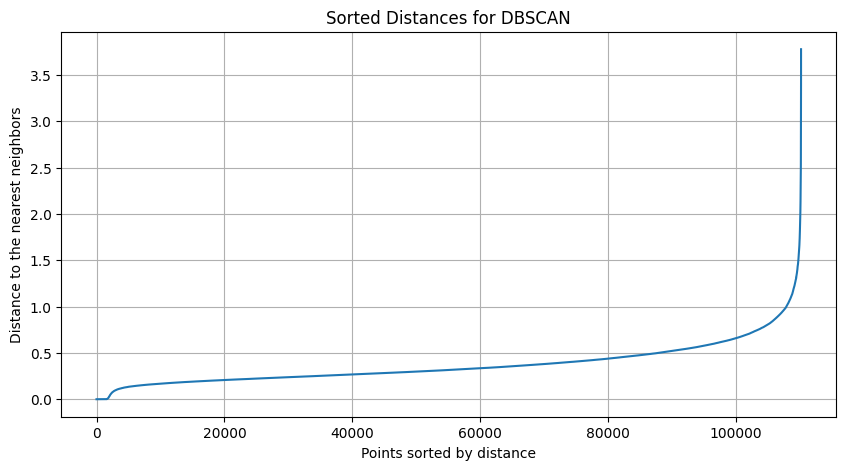

In [31]:
distances_sorted = np.sort(distances, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances_sorted[:, 1])
plt.title("Sorted Distances for DBSCAN")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to the nearest neighbors")
plt.grid()
plt.show()

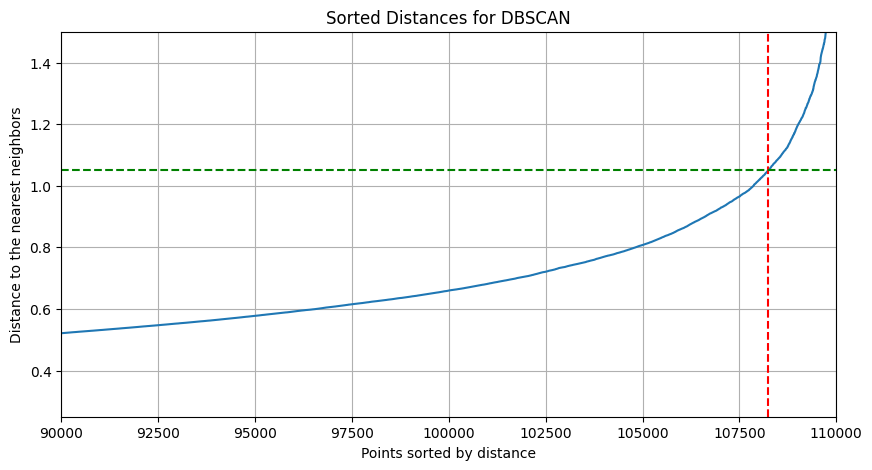

Epsilon threshold:  1.0503509299006546


In [32]:
potential_x = 108250

plt.figure(figsize=(10, 5))
plt.plot(distances_sorted[:, 1])
plt.title("Sorted Distances for DBSCAN")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to the nearest neighbors")
plt.axis([90000, 110000, 0.25, 1.5])
plt.axvline(x=potential_x, color="r", linestyle="--", label="Epsilon threshold")
plt.axhline(
    y=distances_sorted[potential_x, 1],
    color="g",
    linestyle="--",
    label="Min samples threshold",
)
plt.grid()
plt.show()
print("Epsilon threshold: ", distances_sorted[potential_x, 1])

In [33]:
epsilon = distances_sorted[potential_x, 1]

Nie da się tutaj wyznaczyć dokładnej wartości epsilon, trzeba to zrobić na oko.

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

Number of clusters: 4
Percentage of noise points: 5.53%
CH-index value: 12327.99


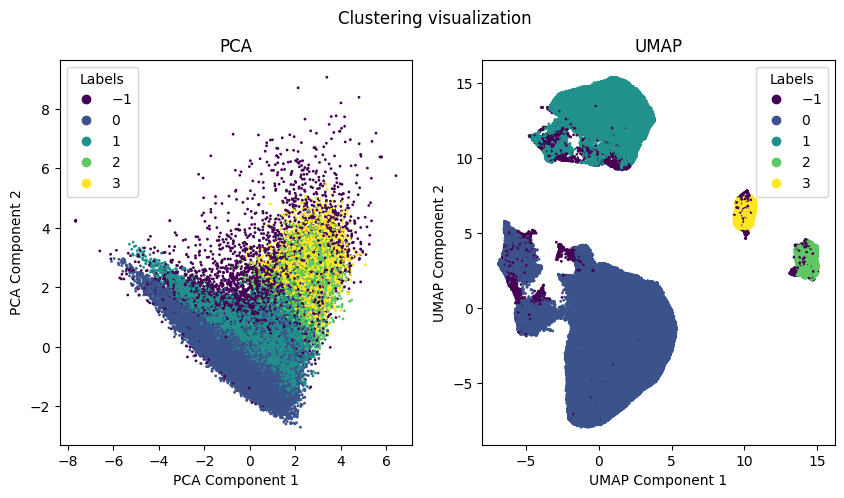

Cluster 0 size: 68598


,Track,Artist
0,Walk On Water,Eddie Money
1,My Lady And Me - 2010 Digital Remaster,Little River Band
2,Hazel,Bob Dylan
3,You Ain't Goin' Nowhere,Bob Dylan
4,Can't Take My Eyes Off You,Engelbert Humperdinck
5,Difícil,El Tri
6,West Bound And Down,Jerry Reed
7,You're so Different Tonight,Smokie
8,"Sigueme, Veras Felicidad",Los Iracundos
9,Lord Have Mercy on the Working Man,Travis Tritt


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'mellow gold', 'soft rock', 'album rock', 'folk rock', 'latin', 'country rock', 'soul']
Cluster 1 size: 28382


,Track,Artist
0,Minchagi Neenu,Sonu Nigam
1,Door To My Heart,Buddy Holly
2,Electric Youth,Debbie Gibson
3,Hide Your Heart,KISS
4,Ya no somos amantes,Daniela Romo
5,Poncho Konos,T3R Elemento
6,Besame Mucho,Luis Miguel
7,Another Man's Woman,Supertramp
8,Hay algo en ella,Dyango
9,The Wild Boys,Duran Duran


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'album rock', 'desi pop', 'mellow gold', 'soft rock', 'latin', 'filmi', 'sufi']
Cluster 2 size: 3769


,Track,Artist
0,Putain d'époque,Lujipeka
1,just like magic,Ariana Grande
2,Broken Clocks,SZA
3,Gang,Mister V
4,Worst Behavior,Drake
5,Augenblick (feat. Summer Cem),KC Rebell
6,HÉ OH,Gambi
7,Luxury,Azealia Banks
8,Guerrilla Radio,Rage Against The Machine
9,okay,LANY


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'southern hip hop', 'pop', 'dance pop', 'hardcore hip hop', 'french hip hop']
Cluster 3 size: 3317


,Track,Artist
0,Soleil,Roméo Elvis
1,Ahora Dice Que Me Ama,Bandaga
2,7 sur 7,Koba LaD
3,Je vous déteste tous,Lorenzo
4,SKRR,KALIM
5,Perdoname,Mora
6,Addiction,Kanye West
7,She's a Bitch,Missy Elliott
8,Cardio,Dosseh
9,"A$AP Forever REMIX (feat. Moby, T.I. & Kid Cudi)",A$AP Rocky


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'french hip hop', 'gangster rap', 'pop urbaine', 'trap', 'pop', 'southern hip hop', 'rap francais']


In [34]:
clustering = DBSCAN(min_samples=min_samples, eps=epsilon, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer.analyze_clustering(X, clustering)

Klasteryzacja już wygląda coraz lepiej, jednak można by jeszcze wydzielić prawdopodobnie podgatunki dla rocka bo clustry są dosyć oczywiste.

DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Number of clusters: 119
Percentage of noise points: 29.07%
CH-index value: 433.69


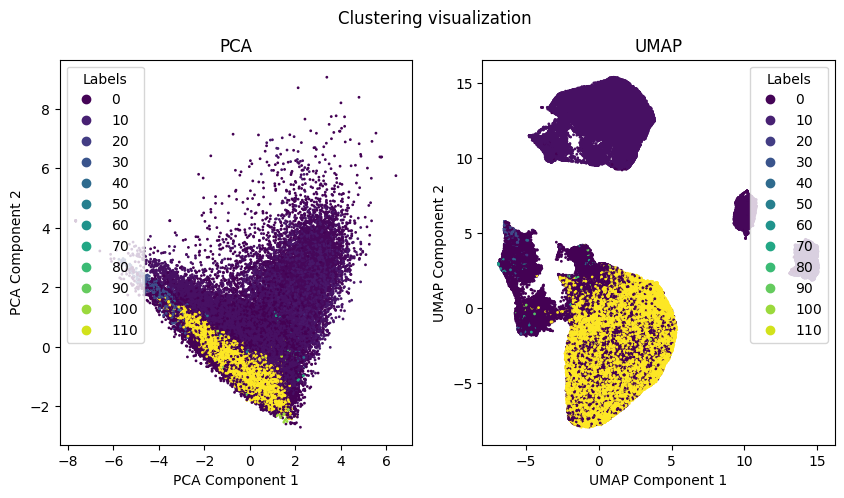

Cluster 118 size: 38103


,Track,Artist
0,Love Is a Many Splendored Thing,Shirley Bassey
1,I Could Have Danced All Night,Chubby Checker
2,Joue pour moi Ianakis,Nana Mouskouri
3,Love Is the Only Thing - Mono Version,Aretha Franklin
4,I'll Do The Same Thing Too,The Shirelles
5,Home,Jerry Lee Lewis
6,By Myself,Aretha Franklin
7,Just Another Lie,Brenda Lee
8,Blues In Hoss' Flat - Blues In Frankie's Flat,Duke Ellington
9,blind,ROLE MODEL


Top 10 genres in the cluster: ['rock', 'adult standards', 'classic rock', 'mellow gold', 'soft rock', 'folk rock', 'album rock', 'latin', 'latin pop', 'brill building pop']
Cluster 4 size: 30373


,Track,Artist
0,Don't Wanna Try,Frankie J
1,Breaks My Heart,Monica
2,Pretty Woman,Shankar-Ehsaan-Loy
3,Love's Divine,Seal
4,Superstar,Usher
5,A Thousand Beautiful Things,Annie Lennox
6,I'm A Mess,Anthony Hamilton
7,This Is How It Goes,Billy Talent
8,I Can't Stop Loving You,Kem
9,What They'll Say About Us,FINNEAS


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'album rock', 'desi pop', 'mellow gold', 'soft rock', 'filmi', 'latin', 'sufi']
Cluster 6 size: 4265


,Track,Artist
0,How Come,D12
1,Just a Moment (feat. Quan),Nas
2,Soul Survivor,Jeezy
3,On Fire,Lloyd Banks
4,Caught Up,Ja Rule
5,Pimpin' All Over The World,Ludacris
6,Gasoline,Seether
7,Thugs Get Lonely Too,2Pac
8,Spend Some Time,Eminem
9,I Love You,Axwell /\ Ingrosso


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'trap', 'southern hip hop', 'pop', 'hardcore hip hop', 'dance pop', 'east coast hip hop']
Cluster 1 size: 3855


,Track,Artist
0,Scholarships,Drake
1,Sorry,Rick Ross
2,No Tellin',Drake
3,Liquor,Chris Brown
4,"Hold You Down (feat. Chris Brown, August Alsin...",DJ Khaled
5,Body Language (feat. Usher & Tinashe),Kid Ink
6,10 Bands,Drake
7,Ghost Town,Adam Lambert
8,Let It Burn,Jazmine Sullivan
9,The Break Up,Machine Gun Kelly


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'french hip hop', 'pop urbaine', 'trap', 'pop', 'southern hip hop', 'hardcore hip hop']
Cluster 26 size: 456


,Track,Artist
0,Easy To Love,Bill Evans
1,The Soft Touch,Henry Mancini
2,On The Side Of The Angels,Oscar Peterson
3,Ae Dard-E-Mohabbat Rok Unhen,Asha Bhosle
4,Marne Ki Duaen Kyon Mangoon,Kishore Kumar
5,I waited for you,Chet Baker
6,Chanson Pour Michelle - Instrumental,Antônio Carlos Jobim
7,Sometime Ago - Remastered,Bill Evans
8,Exactly Like You,Oscar Peterson Trio
9,Ek Nazar Teri Ek Nazar Meri,Lata Mangeshkar


Top 10 genres in the cluster: ['adult standards', 'vocal jazz', 'jazz', 'cool jazz', 'lounge', 'jazz piano', 'bebop', 'stride', 'desi pop', 'filmi']


In [35]:
clustering = HDBSCAN(core_dist_n_jobs=-1)
clustering.fit(X)

hdbscan_analyzer = HDBSCANAnalyzer(df_housing_songs_info, clustering_visualizer)
hdbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?

In [36]:
from joblib import Memory

memory = Memory("./cachedir", verbose=0)

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Number of clusters: 4
Percentage of noise points: 0.51%
CH-index value: 12413.60


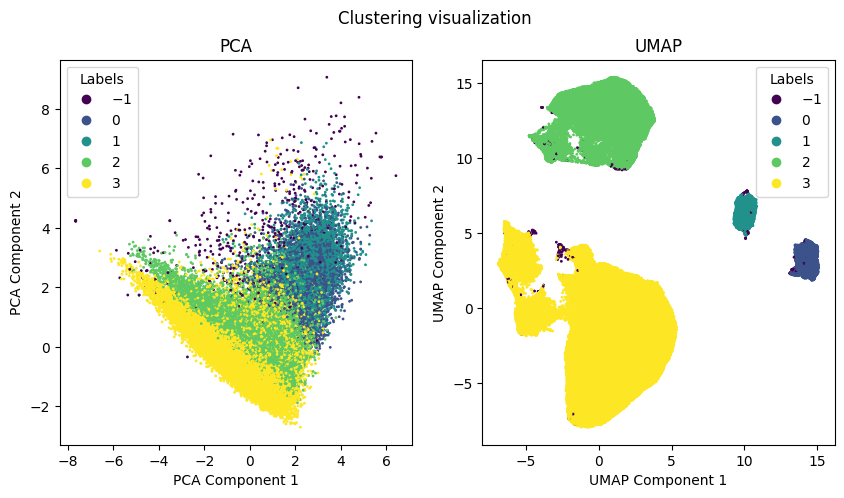

Cluster 3 size: 70979


,Track,Artist
0,Take a Chance on Me,Erasure
1,Forever,Chris Brown
2,Letting Go,Hogland
3,Over When It's Over,Eric Church
4,Ya No Quiero,Jesse & Joy
5,Why Do You Feel So Down,Declan McKenna
6,Un Regalo De Amor,Liberación
7,Bait A Hook,Justin Moore
8,Butterfly - Extreme Mix,Crazy Town
9,MYSTIC LADY,T. Rex


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'mellow gold', 'soft rock', 'album rock', 'folk rock', 'latin', 'country rock', 'soul']
Cluster 2 size: 30321


,Track,Artist
0,Come As You Are,Nirvana
1,Pyaar Aaya,Alisha Chinai
2,Losing My Religion,R.E.M.
3,Enter Sandman,Metallica
4,Dile,Grupo 5
5,Paint Me Down - 2010 Remaster,Spandau Ballet
6,Thick And Thin,LANY
7,행복했던 날들이었다 days gone by,DAY6
8,Trophy,Siouxsie and the Banshees
9,Kings And Queens,Aerosmith


Top 10 genres in the cluster: ['rock', 'classic rock', 'adult standards', 'album rock', 'desi pop', 'mellow gold', 'soft rock', 'filmi', 'latin', 'sufi']
Cluster 0 size: 4466


,Track,Artist
0,Celebration,The Game
1,Where Them Girls At (feat. Nicki Minaj & Flo R...,David Guetta
2,Heart Attack,Trey Songz
3,Crack Rock,Frank Ocean
4,Poe Mans Dreams (His Vice) (feat. GLC),Kendrick Lamar
5,Diced Pineapples,Rick Ross
6,Pursuit Of Happiness - Extended Steve Aoki Rem...,Kid Cudi
7,Bite My Tongue,You Me At Six
8,Welcome To The Jungle,JAY-Z
9,I Love You,Axwell /\ Ingrosso


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'southern hip hop', 'trap', 'pop', 'hardcore hip hop', 'dance pop', 'rock']
Cluster 1 size: 3829


,Track,Artist
0,Gimme Tha Power,Molotov
1,On It,Jazmine Sullivan
2,Cash Still Rules / Scary Hours (Still Don't No...,Wu-Tang Clan
3,Un Beso de Desayuno,Calle 13
4,Re-Humanise Yourself,The Police
5,P*$$Y Fairy (OTW),Jhené Aiko
6,Why Do You Lie To Me (feat. Lil Baby),Topic
7,PERSIAN RUGS,PARTYNEXTDOOR
8,Need It,Migos
9,The Break Up,Machine Gun Kelly


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'gangster rap', 'french hip hop', 'pop urbaine', 'trap', 'pop', 'southern hip hop', 'rap francais']


In [37]:
clusteing_hdbscan = HDBSCAN(
    min_samples=10, min_cluster_size=3000, core_dist_n_jobs=-1, memory=memory
)
clusteing_hdbscan.fit(X)

hdbscan_analyzer.analyze_clustering(X, clusteing_hdbscan)

Klastry wyglądają o wiele lepiej. Lepiej wygladajacy klastering dawał lepszy CH index. Cieżko powiedzieć skąd bierze się ciekawe zjawisko, że niby dość dobrze rozrónione klastry 2 i 3, oba nadal zawierają powtarzające się gatunki - będące podgatunkiem rocka, za to dobrze rozróżniamy hip hop od bardziej agresywnego rapu.

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?

In [38]:
df_housing = pd.read_parquet("ames_data.parquet")
df_housing.head()

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,None,IR1,Lvl,...,0,None,None,None,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,None,Reg,Lvl,...,0,None,MnPrv,None,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,None,IR1,Lvl,...,0,None,None,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,None,Reg,Lvl,...,0,None,None,None,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,None,IR1,Lvl,...,0,None,MnPrv,None,0,3,2010,WD,Normal,189900


In [39]:
df_housing.columns = [col.replace(".", "") for col in df_housing.columns]

df_housing = df_housing.drop(["Order", "PID"], axis="columns")
df_housing = df_housing.loc[~df_housing["Neighborhood"].isin(["GrnHill", "Landmrk"]), :]

df_housing = df_housing.loc[df_housing["GrLivArea"] <= 4000, :]

df_housing.loc[:, "SalePrice"] = np.log1p(df_housing.loc[:, "SalePrice"])


def replace_na(df_housing: pd.DataFrame, col: str, value) -> None:
    df_housing.loc[:, col] = df_housing.loc[:, col].fillna(value)


# Alley : data description says NA means "no alley access"
replace_na(df_housing, "Alley", value="None")

# BedroomAbvGr : NA most likely means 0
replace_na(df_housing, "BedroomAbvGr", value=0)

# BsmtQual etc : data description says NA for basement features is "no basement"
replace_na(df_housing, "BsmtQual", value="No")
replace_na(df_housing, "BsmtCond", value="No")
replace_na(df_housing, "BsmtExposure", value="No")
replace_na(df_housing, "BsmtFinType1", value="No")
replace_na(df_housing, "BsmtFinType2", value="No")
replace_na(df_housing, "BsmtFullBath", value=0)
replace_na(df_housing, "BsmtHalfBath", value=0)
replace_na(df_housing, "BsmtUnfSF", value=0)

# Condition : NA most likely means Normal
replace_na(df_housing, "Condition1", value="Norm")
replace_na(df_housing, "Condition2", value="Norm")

# Electrical : NA most likely means standard
replace_na(df_housing, "Electrical", value="SBrkr")

# External stuff : NA most likely means average
replace_na(df_housing, "ExterCond", value="TA")
replace_na(df_housing, "ExterQual", value="TA")

# Fence : data description says NA means "no fence"
replace_na(df_housing, "Fence", value="No")

# Functional : data description says NA means typical
replace_na(df_housing, "Functional", value="Typ")

# GarageType etc : data description says NA for garage features is "no garage"
replace_na(df_housing, "GarageType", value="No")
replace_na(df_housing, "GarageFinish", value="No")
replace_na(df_housing, "GarageQual", value="No")
replace_na(df_housing, "GarageCond", value="No")
replace_na(df_housing, "GarageArea", value=0)
replace_na(df_housing, "GarageCars", value=0)

# HalfBath : NA most likely means no half baths above grade
replace_na(df_housing, "HalfBath", value=0)

# HeatingQC : NA most likely means typical
replace_na(df_housing, "HeatingQC", value="Ta")

# KitchenAbvGr : NA most likely means 0
replace_na(df_housing, "KitchenAbvGr", value=0)

# KitchenQual : NA most likely means typical
replace_na(df_housing, "KitchenQual", value="TA")

# LotFrontage : NA most likely means no lot frontage
replace_na(df_housing, "LotFrontage", value=0)

# LotShape : NA most likely means regular
replace_na(df_housing, "LotShape", value="Reg")

# MasVnrType : NA most likely means no veneer
replace_na(df_housing, "MasVnrType", value="None")
replace_na(df_housing, "MasVnrArea", value=0)

# MiscFeature : data description says NA means "no misc feature"
replace_na(df_housing, "MiscFeature", value="No")
replace_na(df_housing, "MiscVal", value=0)

# OpenPorchSF : NA most likely means no open porch
replace_na(df_housing, "OpenPorchSF", value=0)

# PavedDrive : NA most likely means not paved
replace_na(df_housing, "PavedDrive", value="N")

# PoolQC : data description says NA means "no pool"
replace_na(df_housing, "PoolQC", value="No")
replace_na(df_housing, "PoolArea", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df_housing, "SaleCondition", value="Normal")

# ScreenPorch : NA most likely means no screen porch
replace_na(df_housing, "ScreenPorch", value=0)

# TotRmsAbvGrd : NA most likely means 0
replace_na(df_housing, "TotRmsAbvGrd", value=0)

# Utilities : NA most likely means all public utilities
replace_na(df_housing, "Utilities", value="AllPub")

# WoodDeckSF : NA most likely means no wood deck
replace_na(df_housing, "WoodDeckSF", value=0)

# CentralAir : NA most likely means No
replace_na(df_housing, "CentralAir", value="N")

# EnclosedPorch : NA most likely means no enclosed porch
replace_na(df_housing, "EnclosedPorch", value=0)

# FireplaceQu : data description says NA means "no fireplace"
replace_na(df_housing, "FireplaceQu", value="No")
replace_na(df_housing, "Fireplaces", value=0)

# SaleCondition : NA most likely means normal sale
replace_na(df_housing, "SaleCondition", value="Normal")

df_housing = df_housing.replace(
    {
        "MSSubClass": {
            20: "SC20",
            30: "SC30",
            40: "SC40",
            45: "SC45",
            50: "SC50",
            60: "SC60",
            70: "SC70",
            75: "SC75",
            80: "SC80",
            85: "SC85",
            90: "SC90",
            120: "SC120",
            150: "SC150",
            160: "SC160",
            180: "SC180",
            190: "SC190",
        },
        "MoSold": {
            1: "Jan",
            2: "Feb",
            3: "Mar",
            4: "Apr",
            5: "May",
            6: "Jun",
            7: "Jul",
            8: "Aug",
            9: "Sep",
            10: "Oct",
            11: "Nov",
            12: "Dec",
        },
    }
)

df_housing = df_housing.replace(
    {
        "Alley": {"None": 0, "Grvl": 1, "Pave": 2},
        "BsmtCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"No": 0, "Mn": 1, "Av": 2, "Gd": 3},
        "BsmtFinType1": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtFinType2": {
            "No": 0,
            "Unf": 1,
            "LwQ": 2,
            "Rec": 3,
            "BLQ": 4,
            "ALQ": 5,
            "GLQ": 6,
        },
        "BsmtQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "Functional": {
            "Sal": 1,
            "Sev": 2,
            "Maj2": 3,
            "Maj1": 4,
            "Mod": 5,
            "Min2": 6,
            "Min1": 7,
            "Typ": 8,
        },
        "GarageCond": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
        "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
        "PavedDrive": {"N": 0, "P": 1, "Y": 2},
        "PoolQC": {"No": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
        "Street": {"Grvl": 1, "Pave": 2},
        "Utilities": {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4},
    }
)

y = df_housing.pop("SalePrice")

C:\Users\lukasz\AppData\Local\Temp\ipykernel_2080\1654520988.py:8: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.27839796 11.56172515 12.05525557 ... 11.79056478 12.0435596
 12.14420256]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\lukasz\AppData\Local\Temp\ipykernel_2080\1654520988.py:157: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [40]:
df_housing

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,SC20,RL,141.0,31770,2,0,3,Lvl,4,Corner,...,0,0,0,No,No,0,May,2010,WD,Normal
1,SC20,RH,80.0,11622,2,0,4,Lvl,4,Inside,...,120,0,0,MnPrv,No,0,Jun,2010,WD,Normal
2,SC20,RL,81.0,14267,2,0,3,Lvl,4,Corner,...,0,0,0,No,Gar2,12500,Jun,2010,WD,Normal
3,SC20,RL,93.0,11160,2,0,4,Lvl,4,Corner,...,0,0,0,No,No,0,Apr,2010,WD,Normal
4,SC60,RL,74.0,13830,2,0,3,Lvl,4,Inside,...,0,0,0,MnPrv,No,0,Mar,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,SC80,RL,37.0,7937,2,0,3,Lvl,4,CulDSac,...,0,0,0,GdPrv,No,0,Mar,2006,WD,Normal
2926,SC20,RL,0.0,8885,2,0,3,Low,4,Inside,...,0,0,0,MnPrv,No,0,Jun,2006,WD,Normal
2927,SC85,RL,62.0,10441,2,0,4,Lvl,4,Inside,...,0,0,0,MnPrv,Shed,700,Jul,2006,WD,Normal
2928,SC20,RL,77.0,10010,2,0,4,Lvl,4,Inside,...,0,0,0,No,No,0,Apr,2006,WD,Normal


In [41]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_num = df_housing.select_dtypes(exclude="object")

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

X_num = numerical_pipeline.fit_transform(X_num)

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



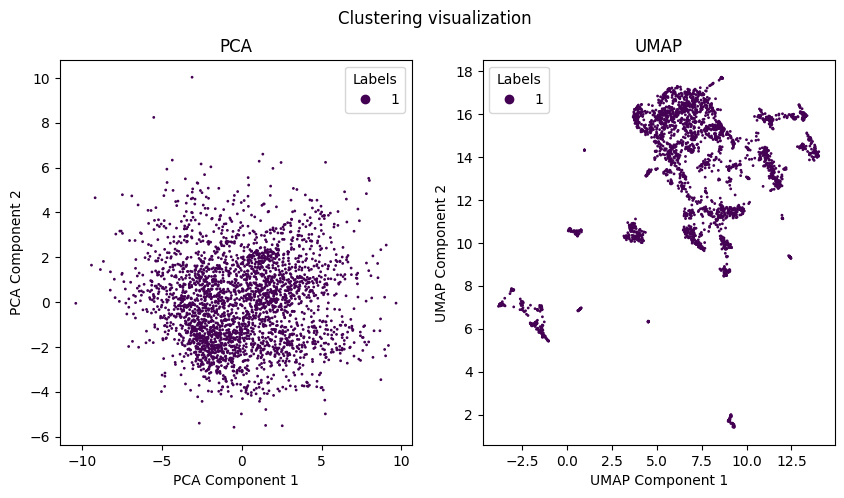

In [42]:
visualizer = ClusteringVisualizer(X_num)
visualizer.visualize()

In [43]:
from joblib import Memory

memory = Memory("./cachedir", verbose=0)

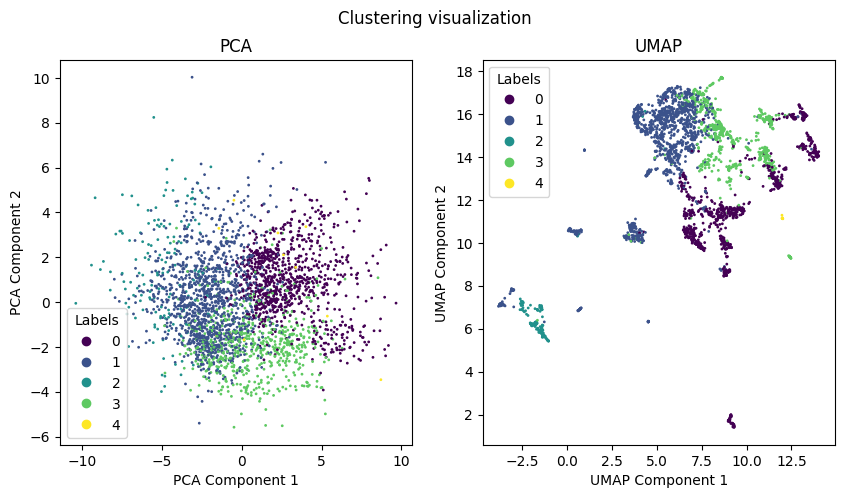

In [59]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(
    linkage="ward",
    metric="euclidean",
    memory=memory,
    n_clusters=None,
    distance_threshold=100,
)
agglomerative_clustering.fit(X_num)
visualizer.visualize(agglomerative_clustering.labels_)

In [45]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

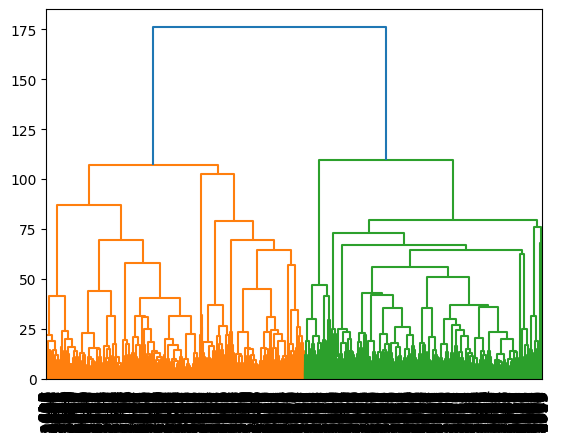

In [64]:
plot_dendrogram(agglomerative_clustering, leaf_rotation=90, leaf_font_size=12)

In [65]:
calinski_harabasz_score(X_num, agglomerative_clustering.labels_)

189.64398763450527

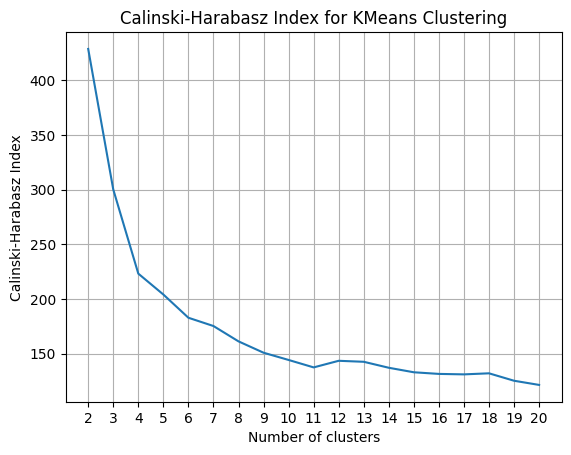

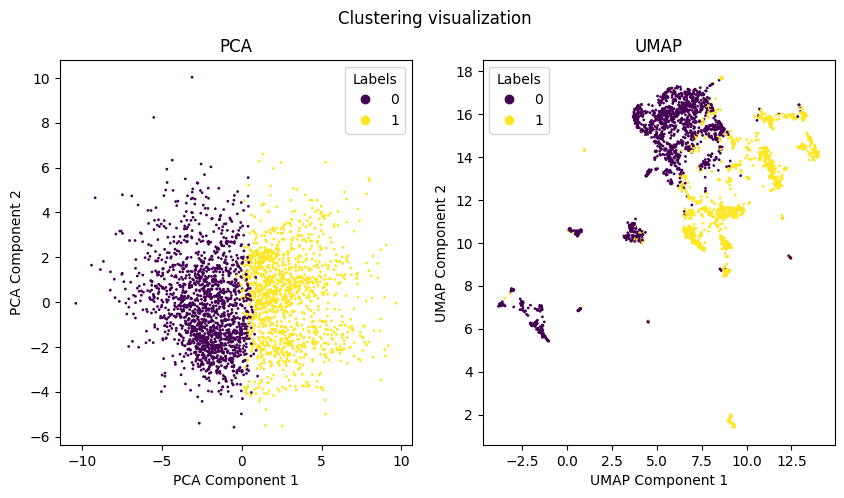

In [66]:
calinski_harabasz_scores = []
best_clustering = None
best_score = -np.inf

for k in range(2, 21):
    kmean = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmean.fit(X_num)

    calinski_harabasz_score_value = calinski_harabasz_score(X_num, kmean.labels_)
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

    if calinski_harabasz_score_value > best_score:
        best_score = calinski_harabasz_score_value
        best_clustering = kmean

plt.plot(calinski_harabasz_scores)
plt.title("Calinski-Harabasz Index for KMeans Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.xticks(range(len(calinski_harabasz_scores)), range(2, 21))
plt.grid()
visualizer.visualize(best_clustering.labels_)

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\Documents\Projects\Machine-Learning-Basics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



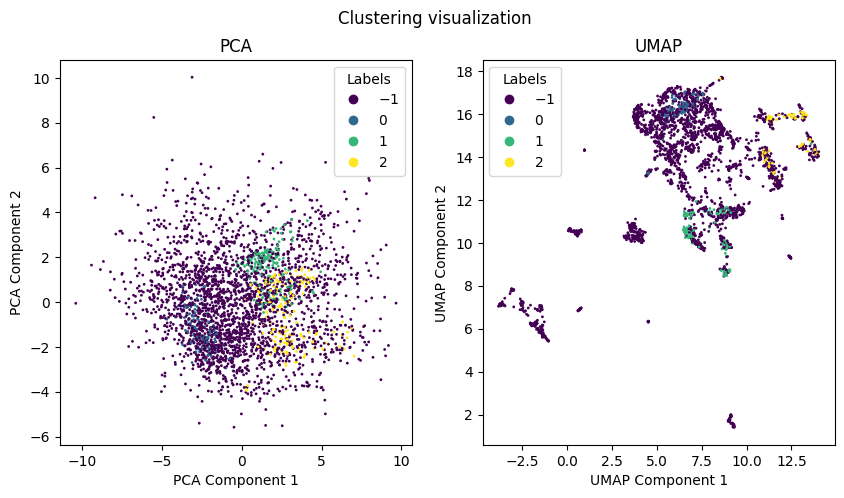

In [74]:
ames_hdbscan = HDBSCAN(
    min_samples=15, min_cluster_size=30, core_dist_n_jobs=-1, memory=memory
)
ames_hdbscan.fit(X_num)

visualizer.visualize(ames_hdbscan.labels_)

In [77]:
print(calinski_harabasz_score(X_num, ames_hdbscan.labels_))

41.462376972909304


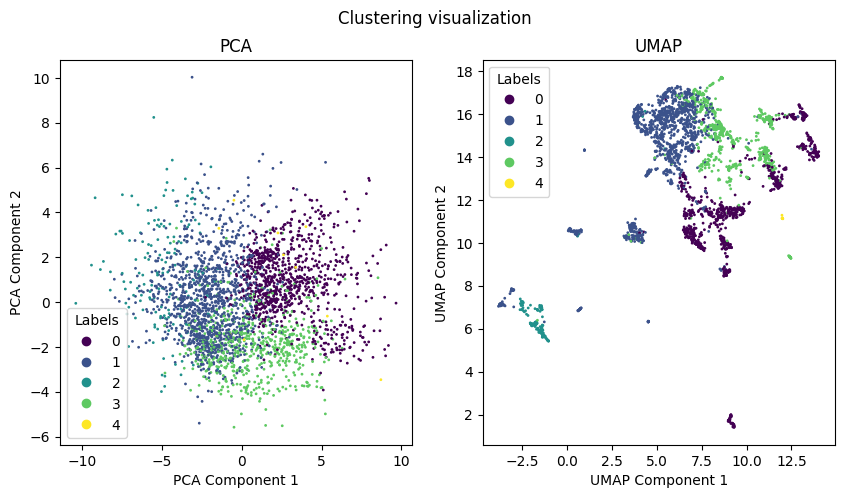

In [78]:
visualizer.visualize(agglomerative_clustering.labels_)

Klasyfikacja hierarichiczna wydaje się dawać faktycznie najlepsze rezultaty. Sprawdźmy zróżnicowanie.

In [103]:
for label in np.unique(agglomerative_clustering.labels_):
    if label == -1:
        continue
    houses = X_num.iloc[agglomerative_clustering.labels_ == label]

    print(f"Cluster {label} size: {len(houses)}")
    print("Top 5 houses in the cluster by SalePrice:")
    display(houses.head(5))

Cluster 0 size: 908
Top 5 houses in the cluster by SalePrice:


,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
3,1.073997,0.135340,0.064216,-0.253421,0.704117,0.030223,0.216144,0.650206,-0.507273,-0.108491,...,0.314852,-0.741723,-0.708871,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
7,-0.439521,-0.655419,0.064216,-0.253421,-1.055874,0.030223,0.216144,1.362848,-0.507273,0.685031,...,0.314852,-0.741723,0.522672,-0.359392,-0.103277,2.278862,-0.057475,-0.05696,-0.095165,1.675889
9,0.075075,-0.334876,0.064216,-0.253421,0.704117,0.030223,0.216144,0.650206,-0.507273,0.916475,...,0.314852,0.369021,0.192258,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
10,0.529131,-0.013690,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.062435,-0.507273,0.718094,...,0.314852,0.503897,0.552710,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
12,0.165886,-0.218992,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.062435,-0.507273,0.883411,...,0.314852,-0.741723,0.417541,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889


Cluster 1 size: 1241
Top 5 houses in the cluster by SalePrice:


,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
1,0.680482,0.194695,0.064216,-0.253421,0.704117,0.030223,0.216144,-0.775077,0.391606,-0.339935,...,0.314852,0.369021,-0.708871,-0.359392,-0.103277,1.851423,-0.057475,-0.05696,-0.095165,1.675889
2,0.710753,0.534510,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.062435,0.391606,-0.439126,...,0.314852,2.376293,-0.168193,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,26.365608,1.675889
4,0.498860,0.478366,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.775077,-0.507273,0.850348,...,0.314852,0.940260,-0.198231,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
5,0.619942,-0.016517,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.062435,0.391606,0.883411,...,0.314852,2.114474,-0.168193,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
11,-1.741147,-0.273208,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.062435,1.290486,0.685031,...,0.314852,3.090342,-0.393475,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,0.963266,1.675889


Cluster 2 size: 159
Top 5 houses in the cluster by SalePrice:


,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
27,0.377779,0.050547,0.064216,-0.253421,0.704117,0.030223,0.216144,-1.487719,-0.507273,-0.009301,...,0.314852,-0.741723,-0.708871,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
119,0.589671,-0.101053,0.064216,-0.253421,-1.055874,0.030223,0.216144,-1.487719,-0.507273,-0.406062,...,0.314852,2.051003,-0.708871,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,0.751579,1.675889
125,1.225349,0.405136,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.775077,0.391606,-0.306872,...,0.314852,-0.741723,-0.708871,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
129,-0.227629,-0.372519,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.775077,1.290486,-0.439126,...,0.314852,0.186541,-0.708871,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
130,-0.076277,-0.611096,0.064216,-0.253421,-1.055874,0.030223,0.216144,-2.200361,-3.203913,-1.034267,...,0.314852,1.344888,-0.708871,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,0.857423,1.675889


Cluster 3 size: 603
Top 5 houses in the cluster by SalePrice:


,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
0,2.526975,2.783196,0.064216,-0.253421,-1.055874,0.030223,0.216144,-0.062435,-0.507273,-0.372999,...,-1.547490,0.924392,0.222296,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
6,-0.500062,-0.666340,0.064216,-0.253421,0.704117,0.030223,0.216144,1.362848,-0.507273,0.982602,...,0.314852,-0.741723,-0.708871,2.288396,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
8,-0.560603,-0.606085,0.064216,-0.253421,-1.055874,0.030223,0.216144,1.362848,-0.507273,0.784221,...,0.314852,1.138607,1.573989,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
13,0.831834,0.008921,0.064216,-0.253421,0.704117,0.030223,0.216144,0.650206,-0.507273,0.618904,...,0.314852,0.781582,-0.708871,-0.359392,-0.103277,-0.285777,-0.057475,-0.05696,-0.095165,1.675889
14,-1.741147,-0.422239,0.064216,-0.253421,-1.055874,0.030223,0.216144,1.362848,-0.507273,0.453587,...,0.314852,-0.741723,0.102145,-0.359392,-0.103277,2.207622,-0.057475,-0.05696,-0.095165,1.675889


Cluster 4 size: 11
Top 5 houses in the cluster by SalePrice:


,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
1063,1.467512,0.335760,0.064216,-0.253421,0.704117,0.030223,-3.806616,2.788132,-0.507273,1.048728,...,0.314852,0.480095,0.267352,-0.359392,-0.103277,3.561182,4.309404,22.899688,-0.095165,0.157220
1566,0.559401,-0.029107,0.064216,-0.253421,0.704117,0.030223,0.216144,-0.062435,0.391606,0.189079,...,0.314852,0.868855,-0.708871,-0.359392,-0.103277,-0.285777,17.410041,17.160526,-0.095165,0.157220
1940,0.529131,-0.073816,0.064216,-0.253421,0.704117,0.030223,0.216144,-1.487719,0.391606,-0.604443,...,0.314852,1.043400,-0.708871,-0.359392,-0.103277,-0.285777,11.102327,11.421364,-0.095165,-0.602114
2089,1.406971,1.774672,0.064216,-0.253421,0.704117,0.030223,0.216144,-0.062435,-0.507273,0.420523,...,-1.547490,-0.741723,2.219798,15.402738,-0.103277,-0.285777,13.407068,11.421364,-0.095165,-0.602114
2230,0.377779,1.019757,0.064216,-0.253421,-1.055874,0.030223,0.216144,1.362848,-0.507273,0.486650,...,0.314852,0.971996,0.252334,2.272821,-0.103277,-0.285777,6.856750,22.899688,-0.095165,-0.602114


Widać jakieś zróżnicowanie np. 

Cluster 4 - grupuje domy z basenem, w innych klastrach nie ma domów z basenami

Cluster 1 i 2 mają wyraźnie niższe LotArea 